In [35]:
import CloudClassificationDatasetCNN
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as v2
import torch.nn as nn
import torch.optim as optim
import numpy as np
batch_size = 7

torch.Size([7, 1, 20, 20])


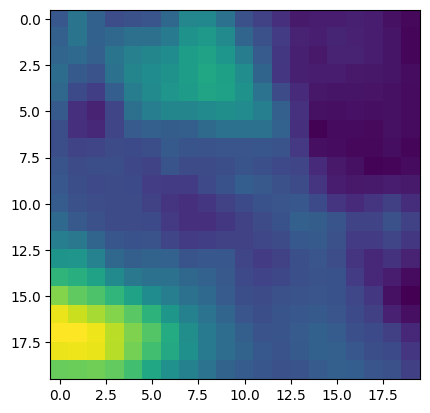

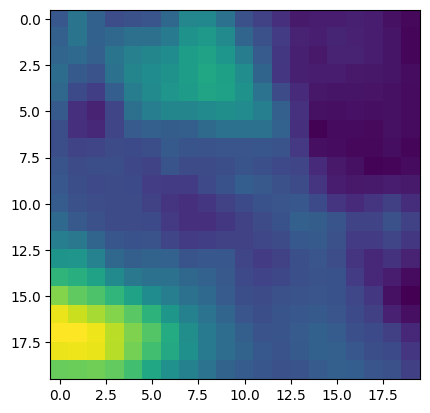

tensor([0, 1])


In [39]:
transform = v2.Compose([
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.Grayscale(),
])

train_dataset = CloudClassificationDatasetCNN.CloudClassificationDataset("data\\2A-netcdfs-cropped-from-nuria","data\\skogs_json_train.npy",channels=("b04","b03","b02","b01","b05","b06","b07","b08","b09","b11","b12"),transform=transform)
val_dataset = CloudClassificationDatasetCNN.CloudClassificationDataset("data\\2A-netcdfs-cropped-from-nuria","data\\skogs_json_val.npy",channels=("b04","b03","b02","b01","b05","b06","b07","b08","b09","b11","b12"),transform=transform)

validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Creates an iterator and plots the pictures
it = iter(training_loader)
images, labels = next(it)
print(images.shape)

plt.figure()
plt.imshow(images[0][:3].permute(1,2,0))
plt.show()
plt.figure()
plt.imshow(images[0][:1].permute(1,2,0))
plt.show()

print(labels[0])

In [41]:
class Cloud(nn.Module):
	def __init__(self, numChannels, classes):
		# call the parent constructor
		super().__init__()


		# initialize first set of CONV => RELU => POOL layers
		# initialize first (and only) set of FC => RELU layers
		self.fc1 = nn.Linear(in_features=numChannels*20*20, out_features=10)
		self.relu1 = nn.ReLU()
		self.fc2 = nn.Linear(in_features=10, out_features=classes)
		self.Softmax = nn.Softmax(dim=1)

	def forward(self, x):
		# pass the input through our first set of CONV => RELU =>
		# POOL layers
		#print(x)
		x = torch.flatten(x, 1)
		#print("f",x)
		x = self.fc1(x)
		#print(x)
		x = self.relu1(x)
		x = self.fc2(x)

		output=self.Softmax(x)
		
		# return the output predictions
		return output

Epoch: 0 batch_nr: 0 Time: 0.15196459999424405 Time_diff: 0.15196540000033565 loss: 1.2241456508636475
Epoch: 0 batch_nr: 13 Time: 1.8265649999957532 Time_diff: 0.11440990000846796 loss: 0.9882538872105735
Epoch: 0 batch_nr: 26 Time: 3.3683707999880426 Time_diff: 0.1126073999912478 loss: 1.0094390334906402

 New best loss: 1.0167185068130493


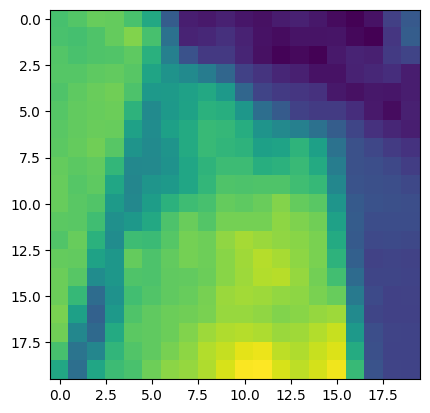

tensor([[1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1]])
tensor([[0.5598, 0.4402],
        [0.5598, 0.4402],
        [0.5598, 0.4402],
        [0.5598, 0.4402],
        [0.5598, 0.4402],
        [0.5598, 0.4402],
        [0.5598, 0.4402]], grad_fn=<SoftmaxBackward0>)
Epoch: 1 batch_nr: 12 Time: 6.339949199988041 Time_diff: 0.1238055000139866 loss: 0.9874485868674058
Epoch: 1 batch_nr: 25 Time: 7.887344899994787 Time_diff: 0.11946850002277642 loss: 1.002067962518105

 New best loss: 0.8266189694404602


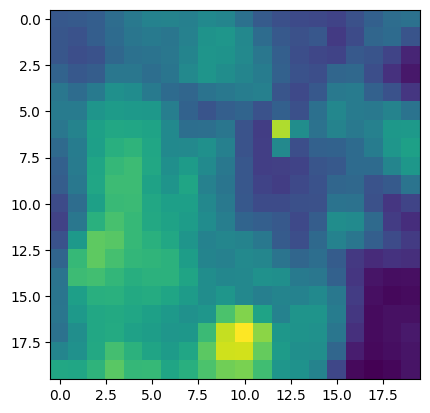

tensor([[1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0]])
tensor([[0.5581, 0.4419],
        [0.5581, 0.4419],
        [0.5581, 0.4419],
        [0.5581, 0.4419],
        [0.5581, 0.4419],
        [0.5581, 0.4419],
        [0.5581, 0.4419]], grad_fn=<SoftmaxBackward0>)
Epoch: 2 batch_nr: 11 Time: 11.176586499990663 Time_diff: 0.14815610001096502 loss: 0.9532912224531174
Epoch: 2 batch_nr: 24 Time: 12.731553399993572 Time_diff: 0.11038790000020526 loss: 1.0165542221069337
Epoch: 2 batch_nr: 37 Time: 14.161137499992037 Time_diff: 0.018060200003674254 loss: 0.9974265914214285
new val loss: 0.8456655740737915
Epoch: 3 batch_nr: 10 Time: 15.535779500001809 Time_diff: 0.12907569998060353 loss: 0.9818514748053118
Epoch: 3 batch_nr: 23 Time: 17.174020799982827 Time_diff: 0.11738660000264645 loss: 1.0072528049349785
Epoch: 3 batch_nr: 36 Time: 18.743610999983503 Time_diff: 0.1297173000057228 loss: 1.0042582573117436
new val loss: 1.010417103

KeyboardInterrupt: 

In [42]:
import copy
from time import perf_counter

epochs=75

def train_model(train_loader, val_loader, model, criterion, optimizer, scheduler):
    start_time = perf_counter()
    time = 0

    best_loss = float('inf')

    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        avg_loss_list = []
        for batch_nr, (images,labels) in enumerate(train_loader):
            
            #Forward pass
            predictions = model(images)
            loss = criterion(predictions,labels.float())
            avg_loss_list.append(loss.item())
            
            if((batch_nr+epoch)%13==0):
                print("Epoch:",epoch,"batch_nr:",batch_nr,"Time:",perf_counter()-start_time,"Time_diff:",perf_counter()-start_time-time,"loss:",(sum(avg_loss_list)/len(avg_loss_list)))
            time=perf_counter()-start_time

            #Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update learning rate
            scheduler.step()
        
        #Grabs next iterator batch, restarts if at end of iterator
        try:
            images_valid, labels_valid = next(iterator)
        except:
            iterator = iter(val_loader)
            images_valid, labels_valid = next(iterator)


        #Forward - Validation
        predictions = model(images_valid)
        v_loss = criterion(predictions,labels_valid.float())
        
        train_loss.append((sum(avg_loss_list)/len(avg_loss_list)))
        val_loss.append(v_loss.item())

        #Finds best model
        if (v_loss<best_loss):
            best_loss=v_loss.item()
            best_model = copy.deepcopy(model)
            torch.save(model, 'ANN1.pt')
            print("\n New best loss:",best_loss)

            
            plt.figure()
            plt.imshow(images_valid[0][:3].permute(1,2,0))
            plt.show()
            
            print(labels_valid)
            print(predictions)
        else:
            print("new val loss:",v_loss.item())
    
    plt.plot(range(1,epochs+1),train_loss, color='r', label='losses')
    plt.plot(range(1,epochs+1),val_loss, color='g', label='losses_valid')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    return best_model

    

model = Cloud(1,2)
optimizer = optim.Adam(model.parameters(),lr=3e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.9)
criterion = nn.CrossEntropyLoss(weight=torch.Tensor([1.0,2.611111111111111])) #weight=torch.Tensor([1.0,2.611111111111111])

best_model=train_model(training_loader,validation_loader,model,criterion,optimizer,scheduler)


In [21]:
test_dataset = CloudClassificationDatasetCNN.CloudClassificationDataset("data\\2A-netcdfs-cropped-from-nuria","data\\skogs_json_test.npy",channels=("b04","b03","b02"),transform=transform)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
model = torch.load("ANN1.pt")
# Creates an iterator and plots the pictures
it = iter(test_loader)



In [18]:
cloud=0
ncloud=0
for batch_nr, (_,labels) in enumerate(training_loader):
    for label in labels:
        if torch.argmax(label).item()==0:
            ncloud+=1
        else:
            cloud+=1

print("cloud:",cloud)
print("ncloud:",ncloud)
print(max(cloud,ncloud)/cloud)
print(max(cloud,ncloud)/ncloud)

cloud: 72
ncloud: 188
2.611111111111111
1.0


In [74]:
def from_one_hot(label):
    return np.argmax(label,0)

In [22]:
CM = [[0,0],
      [0,0]]

correct=0
total=0

for batch_nr, (images,labels) in enumerate(test_loader):
    preds = model(images)
    preds2 = nn.Softmax(dim=1)(preds.detach())
    preds2bin = (torch.zeros(preds2.shape).scatter (1, preds2.argmax(1).unsqueeze(1), 1.0).to(torch.int64))
    for pred, label in zip(preds2bin,labels):
        total+=1
        for a_class in range(2):
            for p_class in range(2):
                if(pred[p_class].item()==1 and label[a_class].item()==1):
                    CM[a_class][p_class] += 1

print(CM[0][0],"\t",CM[0][1])
print(CM[1][0],"\t",CM[1][1])
print(total)

prec = CM[0][0]/(CM[0][0]+CM[1][0])
reca = CM[0][0]/(CM[0][0]+CM[0][1])
f1 = (2*prec*reca)/(prec+reca)
acc = (CM[0][0]+CM[1][1])/total
print("precision:",prec)
print("recall:",reca)
print("f1:",f1)
print("accuracy:",f1)


72 	 0
28 	 0
100
precision: 0.72
recall: 1.0
f1: 0.8372093023255813
accuracy: 0.8372093023255813
